# **Electricity consumption UK 2009-2024**
Historic electricity consumption in the UK (National Grid) between 2009 and 2024


### **Objective:**  To analyze historical electricity demand data and apply time series forecasting methods to predict the electricity demand for 2024.

**Dataset Background:**  National Grid ESO is the electricity system operator for Great Britain. They have gathered information of the electricity demand in Great Britain from 2009. This is updated twice an hour, which means 48 entries per day. This makes this dataset ideal for time series forecasting.

Ever wondered how is electricity generated.
 [Here is a great place to learn.](https://www.nationalgrideso.com/electricity-explained/how-electricity-generated)

# **Importing Required Libraries**

In [ ]:
import warnings

def fxn():
    warnings.warn("FutureWarning", FutureWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

warnings.filterwarnings("ignore")

In [ ]:
!pip install pmdarima
!pip install workalendar
!pip install prophet
!pip install -q --upgrade linear-tree

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 18.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pymeeus: filename=PyMeeus-0.5.12-py3-none-any.whl size=732001 sha256=1388527db9642f3bfb084bc578198ec057352cf8b2f14a7034b74cae39de3fb3
  Stored in directory: /root/.cache/pip/wheels/d6/67/78/aa2e8d108639dd23a5e9e72a4fc88bb44f5541894382712f48
Successfully built pymeeus


In [ ]:
import datetime
import json
import os
from joblib import Parallel, delayed
from time import sleep, time
import logging

import itertools
import holidays
import keras
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
import datetime as dt
import requests
import seaborn as sns
import statsmodels
import statsmodels.tsa.api as sm
import tensorflow as tf
import xgboost as xgb


In [ ]:
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from lineartree import LinearBoostRegressor
from matplotlib import rcParams  # Used to set default paremeters
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import month_plot, plot_acf, plot_pacf, quarter_plot
from workalendar.europe import UnitedKingdom

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# **EDA and Feature Engineering**

In this section, I will go through several steps to understand and transform the original dataset. The steps I will follow are:



*   **Data understanding:** Have a first look at the timeseries dataset
*   **Data preparation:** Deal with null values, drop uninformative features and remove outliers

*   **Feature understanding:** Understand the trend and different seasonalities in the data

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/Independent Study/historic_demand_2009_2024.csv", index_col=0)

In [ ]:
df.head(5)

,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,...,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,nsl_flow,eleclink_flow,scottish_transfer,viking_flow,is_holiday
0,2009-01-01,1,37910,38704,33939,54,1403,0,0,0,...,0,0,-161,0,0,NaN,NaN,NaN,NaN,1
1,2009-01-01,2,38047,38964,34072,53,1403,0,0,0,...,0,0,-160,0,0,NaN,NaN,NaN,NaN,1
2,2009-01-01,3,37380,38651,33615,53,1403,0,0,0,...,0,0,-160,0,0,NaN,NaN,NaN,NaN,1
3,2009-01-01,4,36426,37775,32526,50,1403,0,0,0,...,0,0,-160,0,0,NaN,NaN,NaN,NaN,1
4,2009-01-01,5,35687,37298,31877,50,1403,0,0,0,...,0,0,-160,0,0,NaN,NaN,NaN,NaN,1


In [ ]:
df.head().T

,0,1,2,3,4
settlement_date,2009-01-01,2009-01-01,2009-01-01,2009-01-01,2009-01-01
settlement_period,1,2,3,4,5
nd,37910,38047,37380,36426,35687
tsd,38704,38964,38651,37775,37298
england_wales_demand,33939,34072,33615,32526,31877
embedded_wind_generation,54,53,53,50,50
embedded_wind_capacity,1403,1403,1403,1403,1403
embedded_solar_generation,0,0,0,0,0
embedded_solar_capacity,0,0,0,0,0
non_bm_stor,0,0,0,0,0


In [ ]:
df.shape

(264816, 22)

In [ ]:
df.describe()

,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,...,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,nsl_flow,eleclink_flow,scottish_transfer,viking_flow,is_holiday
count,264816.000000,264816.000000,264816.000000,264816.000000,264816.000000,264816.000000,264816.000000,264816.000000,264816.000000,264816.000000,...,264816.000000,264816.000000,264816.00000,264816.000000,264816.000000,89520.000000,89520.000000,19392.000000,19392.000000,264816.000000
mean,24.500227,31504.537358,32921.045749,28667.755774,1242.966573,4331.097245,829.066148,8219.825075,7.017265,311.785629,...,27.051949,522.169559,-116.40814,-36.193897,158.027751,299.353318,26.886092,1715.635262,48.664501,0.022838
std,13.853818,7814.098007,7718.003064,7081.245993,949.364302,1943.416081,1637.697117,5676.571492,40.172911,536.573773,...,325.820897,526.095096,227.41281,255.713040,403.361103,589.323838,438.183194,1882.476750,247.753671,0.149389
min,1.000000,13367.000000,0.000000,0.000000,0.000000,1403.000000,0.000000,0.000000,-24.000000,0.000000,...,-1030.000000,-1215.000000,-505.00000,-585.000000,-1022.000000,-1455.000000,-1028.000000,-2851.000000,-1465.000000,0.000000
25%,12.750000,25248.000000,26897.000000,22976.000000,538.000000,2087.000000,0.000000,1930.000000,0.000000,8.000000,...,0.000000,0.000000,-271.00000,-164.000000,0.000000,0.000000,0.000000,232.000000,0.000000,0.000000
50%,24.500000,30890.000000,32124.000000,28103.000000,994.000000,4260.000000,0.000000,10500.000000,0.000000,11.000000,...,0.000000,748.000000,-134.00000,0.000000,0.000000,0.000000,0.000000,1540.000000,0.000000,0.000000
75%,36.250000,37250.000000,38415.250000,33916.000000,1687.000000,6488.000000,792.000000,13080.000000,0.000000,400.000000,...,0.000000,994.000000,37.00000,0.000000,61.000000,693.000000,0.000000,3071.000000,0.000000,0.000000
max,50.000000,59095.000000,60147.000000,53325.000000,5587.000000,6574.000000,9830.000000,15954.000000,893.000000,2019.000000,...,1016.000000,1143.000000,499.00000,504.000000,1033.000000,1401.000000,1002.000000,6238.000000,1412.000000,1.000000


In [ ]:
df.columns

Index(['settlement_date', 'settlement_period', 'nd', 'tsd',
       'england_wales_demand', 'embedded_wind_generation',
       'embedded_wind_capacity', 'embedded_solar_generation',
       'embedded_solar_capacity', 'non_bm_stor', 'pump_storage_pumping',
       'ifa_flow', 'ifa2_flow', 'britned_flow', 'moyle_flow', 'east_west_flow',
       'nemo_flow', 'nsl_flow', 'eleclink_flow', 'scottish_transfer',
       'viking_flow', 'is_holiday'],
      dtype='object')

The columns in the dataset are:

**1. SETTLEMENT_DATA:** date in format dd/mm/yyyy

**2. SETTLEMENT_PERIOD:** half hourly period for the historic outcome occurred.

**3. ND (National Demand).** National Demand is the sum of metered generation. National Demand is calculated as a sum of generation based on National Grid ESO operational generation metering. Measured in MW.

**4. TSD (Transmission System Demand).** Transmission System Demand is equal to the ND plus the additional generation required to meet station load, pump storage pumping and interconnector exports. Measured in MW.

**5. ENGLAND_WALES_DEMAND.** England and Wales Demand, as ND above but on an England and Wales basis. Measured in MW.

**6. EMBEDDED_WIND_GENERATION.** This is an estimate of the GB wind generation from wind farms which do not have Transmission System metering installed. These wind farms are embedded in the distribution network and invisible to National Grid ESO. Their effect is to suppress the electricity demand during periods of high wind. The true output of these generators is not known so an estimate is provided based on National Grid ESO’s best model. Measured in MW.

**7. EMBEDDED_WIND_CAPACITY.** This is National Grid ESO’s best view of the installed embedded wind capacity in GB. This is based on publicly available information compiled from a variety of sources and is not the definitive view. It is consistent with the generation estimate provided above. Measured in MW

**8. EMBEDDED_SOLAR_GENERATION.** This is an estimate of the GB solar generation from PV panels. These are embedded in the distribution network and invisible to National Grid ESO. Their effect is to suppress the electricity demand during periods of high radiation. The true output of these generators is not known so an estimate is provided based on National Grid ESO’s best model. Measured in MW.

**9. EMBEDDED_SOLAR_CAPACITY.** As embedded wind capacity above, but for solar generation. Measured in MW.

**10. NON_BM_STOR** (Non-Balancing Mechanism SHort-Term Operating Reserve). For units that are not included in the ND generator definition. This can be in the form of generation or demand reduction. Measured in MW.

**11. PUMP_STORAGE_PUMPING**. The demand due to pumping at hydro pump storage units; the -ve signifies pumping load.

**12. IFA_FLOW** (IFA Interconnector Flow). The flow on on the respective interconnector. -ve signifies export power out from GB; +ve signifies import power into GB. Measured in MW.

**13. IFA2_FLOW** (IFA Interconnector Flow). The flow on the respective interconnector. -ve signifies export power out from GB; +ve signifies import power into GB. Measured in MW.

**14. MOYLE_FLOW** (Moyle Interconnector FLow). The flow on the respective interconnector. -ve signifies export power out from GB; +ve signifies import power into GB. Measured in MW.

**15. EAST_WEST_FLOW** (East West Innterconnector FLow). The flow on the respective interconnector. -ve signifies export power out from GB; +ve signifies import power into GB. Measured in MW.

**16. NEMO_FLOW** (Nemo Interconnector FLow). The flow on the respective interconnector. -ve signifies export power out from GB; +ve signifies import power into GB. Measured in MW.

**17. 1NSL_FLOW** (North Sea Link Interconnector Flow). The flow on the respective interconnector. -ve signifies export power out from GB; +ve signifies import power into GB. Measured in MW.

**18. ELCLINK_FLOW.** Blank

In [ ]:
df.isna().sum()

settlement_date                   0
settlement_period                 0
nd                                0
tsd                               0
england_wales_demand              0
embedded_wind_generation          0
embedded_wind_capacity            0
embedded_solar_generation         0
embedded_solar_capacity           0
non_bm_stor                       0
pump_storage_pumping              0
ifa_flow                          0
ifa2_flow                         0
britned_flow                      0
moyle_flow                        0
east_west_flow                    0
nemo_flow                         0
nsl_flow                     175296
eleclink_flow                175296
scottish_transfer            245424
viking_flow                  245424
is_holiday                        0
dtype: int64

In [ ]:
df.drop(columns=["nsl_flow", "eleclink_flow","scottish_transfer","viking_flow"], axis=1, inplace=True)

In [ ]:
df['settlement_period'].min(),df['settlement_period'].max()

(1, 50)

Drop rows whose settlement_period exceeds 48, as the data states that 48 is the maximum number of samples per day as each hour has 2 samples.


In [ ]:
df.drop(index=df[df["settlement_period"] > 48].index, inplace=True)

In [ ]:
df.reset_index(drop=True, inplace=True)

In [ ]:
df.shape

(264786, 18)

In [ ]:
df['settlement_date'].min(),df['settlement_date'].max()

('2009-01-01', '2024-02-08')

In [ ]:
# Sort values by date
df.sort_values(by=["settlement_date", "settlement_period"], inplace=True, ignore_index=True)

# **Bank Holidays**

Bank holidays are very important in time series forecasting as they often affect the data values on those days. Therefore, I want to add a new column to my dataset to state whether each day was bank holiday or not. I began by checking the UK governement [bank holiday API](https://github.com/alphagov/calendars), but it only goes back to 2015.

My next option was to check StackOverflow and [check](https://stackoverflow.com/questions/37677112/adding-holidays-columns-in-a-dataframe-in-python) the questions  related to this issue. The asnwers suggest using Python [Workalendar](https://workalendar.github.io/workalendar/), but for some reason it was adding more bank holidays than it should (I verified this using other websites).

Luckily, an entry in [Stack Exchange](https://opendata.stackexchange.com/questions/1926/list-of-public-holidays-by-countries/13215#13215) covered this topic too and one of the answers suggested using [Python holidays](https://github.com/dr-prodigy/python-holidays), which after checking the [Python Holidays API](https://python-holidays.readthedocs.io/en/latest/api.html) I managed to make work for my usecase.

**England, Scotland, Wales, and Northern Ireland,make up the sovereign nation of the UK.**

Since the dataset covers electricity demand for England and Wales, the first step is to check that the two countries have the same bank holidays:

In [ ]:
# Compare England's and Wales' bank holiday
import holidays

bank_holiday_england = holidays.UK(
    subdiv="England", years=range(2009, 2024), observed=True
).items()
bank_holiday_wales = holidays.UK(
    subdiv="Wales", years=range(2009, 2024), observed=True
).items()

print(bank_holiday_england == bank_holiday_wales)

True


Having seen that the bank holidays are the same, I can proceed with this python package to extract the bank holidays and store them in the right format.

It's worth noting that this package includes the original bank holiday and when it was observed. I will only store the observed days.

In [ ]:
# Create empty lists to store data
holiday_names = []
holiday_dates = []
holiday_names_observed = []
holiday_dates_observed = []

for date, name in sorted(bank_holiday_england):
    holiday_dates.append(date)
    holiday_names.append(name)
    # Pop the previous value as observed bank holidays takes place later
    if "Observed" in name:
        holiday_dates_observed.pop()
        holiday_names_observed.pop()
    holiday_names_observed.append(name)
    holiday_dates_observed.append(np.datetime64(date))

holiday_dates_observed[:5]


[numpy.datetime64('2009-01-01'),
 numpy.datetime64('2009-04-10'),
 numpy.datetime64('2009-04-13'),
 numpy.datetime64('2009-05-04'),
 numpy.datetime64('2009-05-25')]

In [ ]:
holiday_names_observed[:5]

["New Year's Day",
 'Good Friday',
 'Easter Monday',
 'May Day',
 'Spring Bank Holiday']

In [ ]:
holiday_dates_observed = [pd.to_datetime(date) for date in holiday_dates_observed]

Once I've verified that the holidays are correctly loaded, one can compare the holiday_dates variable and the date in the dataset and store the boolean output in a new column.

In [ ]:
df["is_holiday"] = df["settlement_date"].apply(
    lambda x: pd.to_datetime(x) in holiday_dates_observed
)

df["is_holiday"] = df["is_holiday"].astype(int)

df[df["is_holiday"] == 1].sample(7)

,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
210215,2020-12-28,48,26025,26741,23581,779,6527,0,13080,0,115,2003,-1,0,401,504,1000,1
250010,2023-04-07,9,20970,23109,18911,775,6545,0,15340,0,578,319,97,-98,-306,-221,2,1
192484,2019-12-25,27,33285,33889,30000,446,6465,3020,13080,0,4,1999,0,1000,77,0,952,1
34791,2010-12-26,44,38220,39277,34423,1071,2141,0,77,0,7,1627,0,0,-450,0,0,1
210202,2020-12-28,35,40986,41590,36888,611,6527,0,13080,0,2,2004,-2,0,279,504,1019,1
109721,2015-04-06,8,24789,26560,22369,246,3989,0,8477,0,1264,1919,0,962,15,-7,0,1
245192,2022-12-27,37,33037,33686,29824,3046,6545,0,13861,0,0,1004,991,973,-49,0,1019,1


The sample dataframe above is ok to make sure that the new column has been created, but one can inspect the bank holidays more easily using a plot.

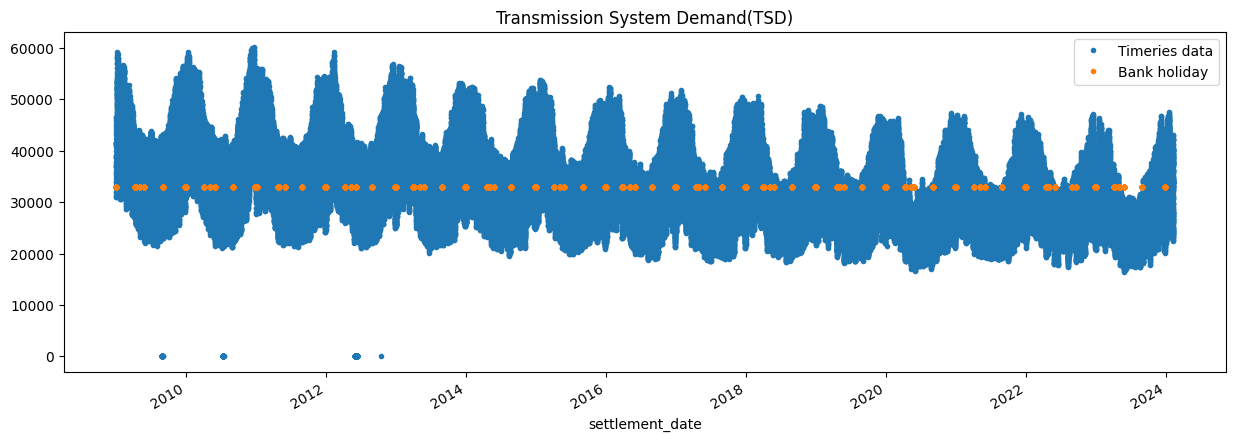

In [ ]:
# Set date as the index and turn into datetime type
df_plot = df.copy()
df_plot = df_plot.set_index("settlement_date")
df_plot.index = pd.to_datetime(df_plot.index)

fig, ax = plt.subplots(figsize=(15, 5))
df_plot["tsd"].plot(
    style=".", ax=ax, title="Transmission System Demand(TSD)", label="Timeries data"
)
(df_plot.query("is_holiday == 1")["is_holiday"] * 33000).plot(
    style=".", ax=ax, label="Bank holiday"
)
ax.legend();

That plot is great to see the behaviour of the time series data. I can see a decreasing trend and a clear yearly seasonality. However, this plot also shows the presence of data points equal to 0. These values will be removed in the next section.

Before dealing with outliers, in the above graph we can see a yearly trend, but we cannot focus on daily or weekly patterns. Therefore, lets create a new plot focusing on a single week

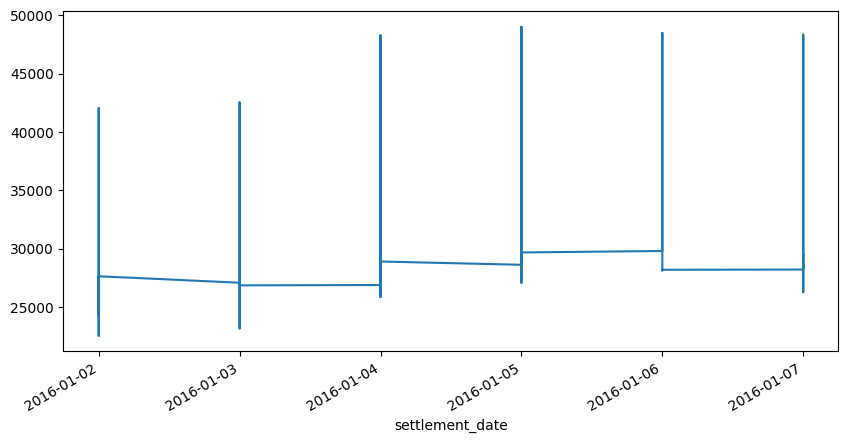

In [ ]:
df_plot.loc[(df_plot.index > "01-01-2016") & (df_plot.index < "01-08-2016")][
    "tsd"
].plot(figsize=(10, 5));

In [ ]:
df_plot.head()

,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
settlement_date,,,,,,,,,,,,,,,,,
2009-01-01,1,37910,38704,33939,54,1403,0,0,0,33,2002,0,0,-161,0,0,1
2009-01-01,2,38047,38964,34072,53,1403,0,0,0,157,2002,0,0,-160,0,0,1
2009-01-01,3,37380,38651,33615,53,1403,0,0,0,511,2002,0,0,-160,0,0,1
2009-01-01,4,36426,37775,32526,50,1403,0,0,0,589,1772,0,0,-160,0,0,1
2009-01-01,5,35687,37298,31877,50,1403,0,0,0,851,1753,0,0,-160,0,0,1


The plot wasn't wrong! In the process of setting the date as the index I haven't added the hour. Therefore, the 48 samples per day are overlayed on top of each other.

Before going forward I need to do two things:

*   Remove outliers
*   Add the hour to the date and set it as the index



# **Outlier analysis**

In the plot above, one can see that there are multiple 0 values. A histogram will show how many samples are actually equal to 0.



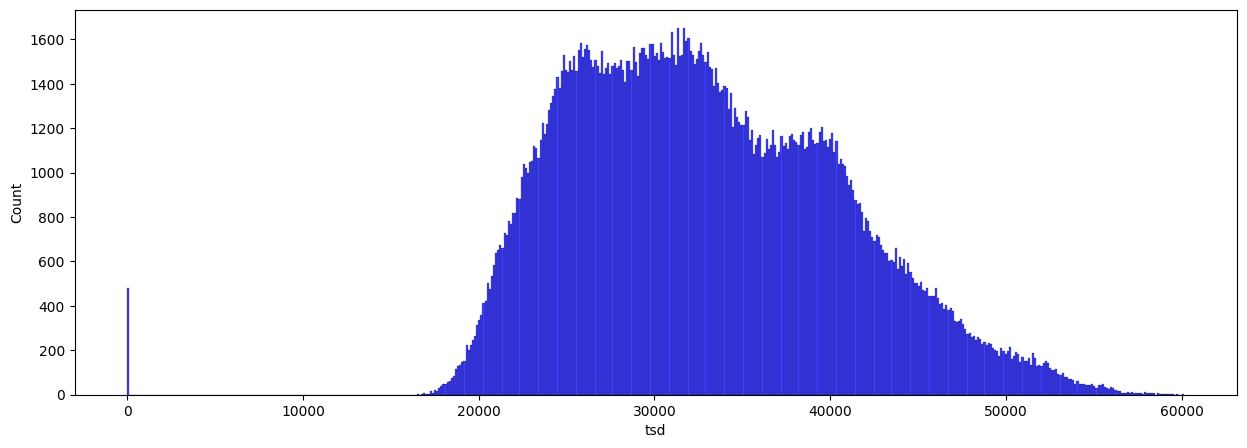

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.histplot(df, x="tsd", bins=500, ax=ax, color="b");

In [ ]:
df.shape

(264786, 18)

In [ ]:
null_days = df.loc[df["tsd"] == 0.0, "settlement_date"].unique().tolist()

null_days_index = []

for day in null_days:
    null_days_index.append(df[df["settlement_date"] == day].index.tolist())

null_days_index = [item for sublist in null_days_index for item in sublist]

df.drop(index=null_days_index, inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
df.shape

(264066, 18)

## **Feature creation**

The first step in the feature creation is to change the date format to include the hourly values. The settlement_period values refer to how many samples have been taken per day. Given that there are 48 samples per day, each sample represents 30 minutes of the day. Using this information together with the valuable knowledge of the [StackOverflow contributors](https://stackoverflow.com/questions/61444409/convert-a-pandas-column-to-hours-and-minutes), I managed to change the date format.

In [ ]:
# Apply lambda function to turn settlement period into hours.
# Settlement period equal to 0 corresponds with 00:00:00 and each
# settlement period adds 30 minutes until settlement period 48, which
# corresponds with 23:30:00
import datetime
df["period_hour"] = (df["settlement_period"]).apply(
    lambda x: str(datetime.timedelta(hours=(x - 1) * 0.5))
)

df.loc[df["period_hour"] == "1 day, 0:00:00", "period_hour"] = "0:00:00"

# Move the new column
column_to_move = df.pop("period_hour")
df.insert(2, "period_hour", column_to_move)

df.sample(n=7)

,settlement_date,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
215256,2021-04-28,3,1:00:00,22166,23897,20183,1447,6527,0,13080,0,1229,1281,-2,0,363,0,811,0
20672,2010-03-09,35,17:00:00,49453,52253,44968,230,1829,0,0,0,11,-1758,0,0,-431,0,0,0
233150,2022-05-05,43,21:00:00,29697,33697,27207,1014,6545,0,13816,0,14,-687,-1028,-555,403,0,-989,0
197158,2020-04-15,47,23:00:00,23070,23679,20887,756,6527,0,13080,0,6,1722,0,860,-103,0,861,0
82504,2013-10-01,3,1:00:00,23488,25497,21498,838,2337,0,3011,0,1394,1360,0,747,-115,0,0,0
31844,2010-11-01,25,12:00:00,42965,43822,39027,442,2139,8,61,0,6,1475,0,0,-251,0,0,0
194048,2020-02-11,7,3:00:00,23661,25866,22079,5097,6465,0,13080,0,1547,1410,0,316,81,504,-58,0


In [ ]:
df.tail()

,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,...,day_of_week,day_of_year,quarter,month,year,week_of_year,lag1,lag2,lag3,is_future
settlement_date,,,,,,,,,,,,,,,,,,,,,
2024-02-08 21:30:00,44,21:30:00,30670,32324,28979,3855,6562,0,15905,0,...,3,39,1,2,2024,6,33780.0,34654.0,37168.0,False
2024-02-08 22:00:00,45,22:00:00,28684,30714,27230,3873,6562,0,15905,0,...,3,39,1,2,2024,6,32353.0,33576.0,35092.0,False
2024-02-08 22:30:00,46,22:30:00,27147,29324,25762,3890,6562,0,15905,0,...,3,39,1,2,2024,6,30609.0,32133.0,33012.0,False
2024-02-08 23:00:00,47,23:00:00,25356,28595,24042,3872,6562,0,15905,0,...,3,39,1,2,2024,6,28221.0,31285.0,31063.0,False
2024-02-08 23:30:00,48,23:30:00,24286,27944,23034,3853,6562,0,15905,0,...,3,39,1,2,2024,6,27131.0,30183.0,29850.0,False


Now we can combine period_hour with settlement_date to create a unique index column

In [ ]:
df["settlement_date"] = pd.to_datetime(
    (df["settlement_date"] + " " + df["period_hour"])
)

df.sample(n=5)

,settlement_date,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
148729,2017-07-11 21:30:00,44,21:30:00,31084,31587,28458,593,5154,0,12372,0,3,1833,0,978,248,494,0,0
71825,2013-02-20 12:30:00,26,12:30:00,46889,48000,42720,1080,2085,318,2389,0,10,821,0,956,-251,-250,0,0
173125,2018-12-02 04:30:00,10,4:30:00,21724,23739,19299,1361,5911,0,13052,0,1408,1659,0,350,186,301,0,0
133277,2016-08-23 22:30:00,46,22:30:00,29245,29829,26545,545,4353,0,11100,0,18,451,0,999,0,-66,0,0
34363,2010-12-23 23:30:00,48,23:30:00,38002,40058,33598,918,2141,0,76,0,1055,1974,0,0,-401,0,0,0


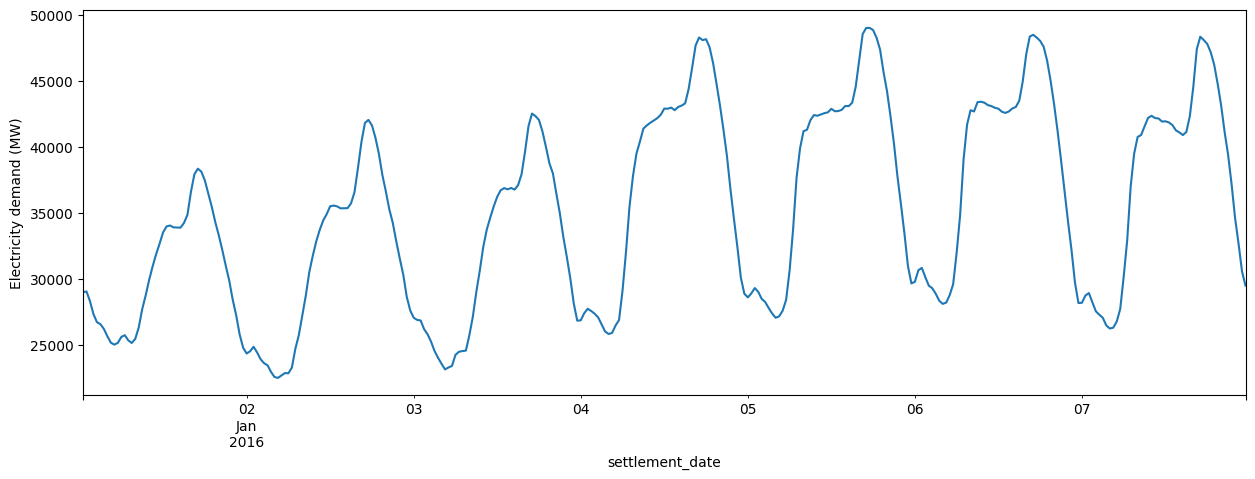

In [ ]:
df.set_index("settlement_date", inplace=True)
df.sort_index(inplace=True)

df.loc[(df.index > "01-01-2016") & (df.index < "01-08-2016")]["tsd"].plot(
    figsize=(15, 5), ylabel="Electricity demand (MW)"
);

While adding extra features will not improve the prediction for the SARIMA models, XGBoost will benefit from it. The new features consists of different bits of information "already stored" in the date, such as the day of the week and the day of the year. Given the seasonality of the time series data, these features might lead to more accurate predictions. The second part is adding lags. Again, XGBoost will benefit from this.

In [ ]:
def create_features(df):
    df = df.copy()
    df["day_of_month"] = df.index.day
    df["day_of_week"] = df.index.day_of_week
    df["day_of_year"] = df.index.day_of_year
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["week_of_year"] = df.index.isocalendar().week.astype("int64")
    return df


def add_lags(df):
    target_map = df["tsd"].to_dict()
    # 364 is chosen instead of 365 becuase 364 is divisible by 4 and that way we don't have to map specific days
    df["lag1"] = (df.index - pd.Timedelta("364 days")).map(target_map)
    df["lag2"] = (df.index - pd.Timedelta("728 days")).map(target_map)
    df["lag3"] = (df.index - pd.Timedelta("1092 days")).map(target_map)
    return df


In [ ]:
df = create_features(df)
df = add_lags(df)

df.sample(n=5)

,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,...,day_of_month,day_of_week,day_of_year,quarter,month,year,week_of_year,lag1,lag2,lag3
settlement_date,,,,,,,,,,,,,,,,,,,,,
2009-05-14 13:00:00,27,13:00:00,41370,42158,37719,667,1673,0,0,8,...,14,3,134,2,5,2009,20,NaN,NaN,NaN
2016-11-28 13:00:00,27,13:00:00,40137,41255,35857,815,5077,3660,11503,0,...,28,0,333,4,11,2016,48,43881.0,45977.0,46848.0
2017-12-22 02:30:00,6,2:30:00,26393,28441,23759,579,5754,0,12916,0,...,22,4,356,4,12,2017,51,28266.0,24319.0,27340.0
2016-09-14 08:30:00,18,8:30:00,33638,34147,30841,1076,4403,1920,11433,0,...,14,2,258,3,9,2016,37,37016.0,37969.0,39110.0
2021-01-06 09:30:00,20,9:30:00,41464,42114,37606,655,6527,642,13080,0,...,6,2,6,1,1,2021,1,40809.0,44104.0,44665.0


## Feature understanding

In this section, I will explore the distribution of electricity demand with respect the different features, such as as hour, month or year. This is a great way to understand the seasonalities in the time series.

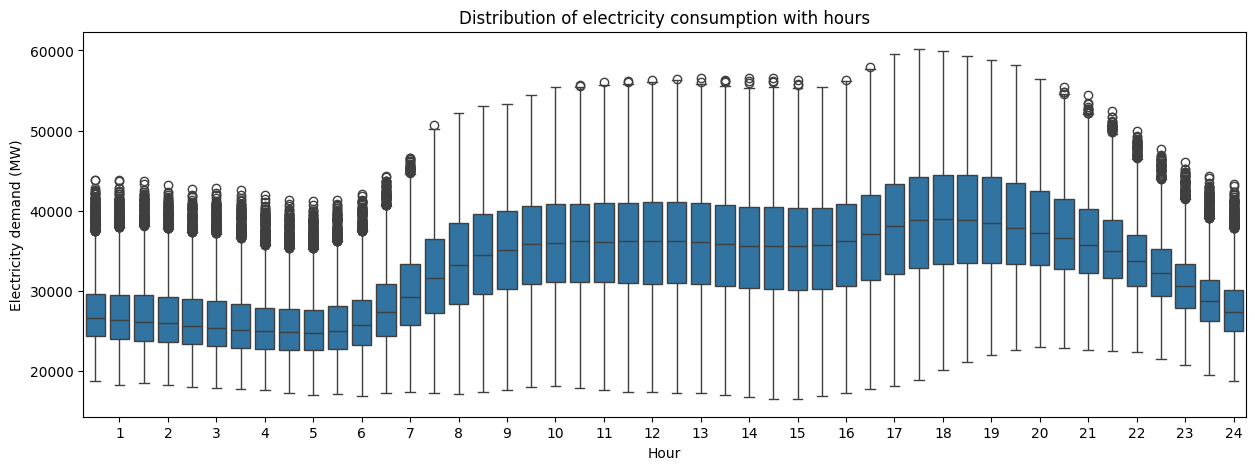

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="settlement_period", y="tsd", data=df)
# Reduce the frequency of the xticks and change the labels to be in the range [0,24] hours
ax.set_xticks(range(1, 49, 2))
ax.set_xticklabels(range(1, 25))
ax.set_xlabel("Hour")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with hours");

We can see from this graph that the maximum consumption of electricity is from 8 a.m. to 6 p.m.

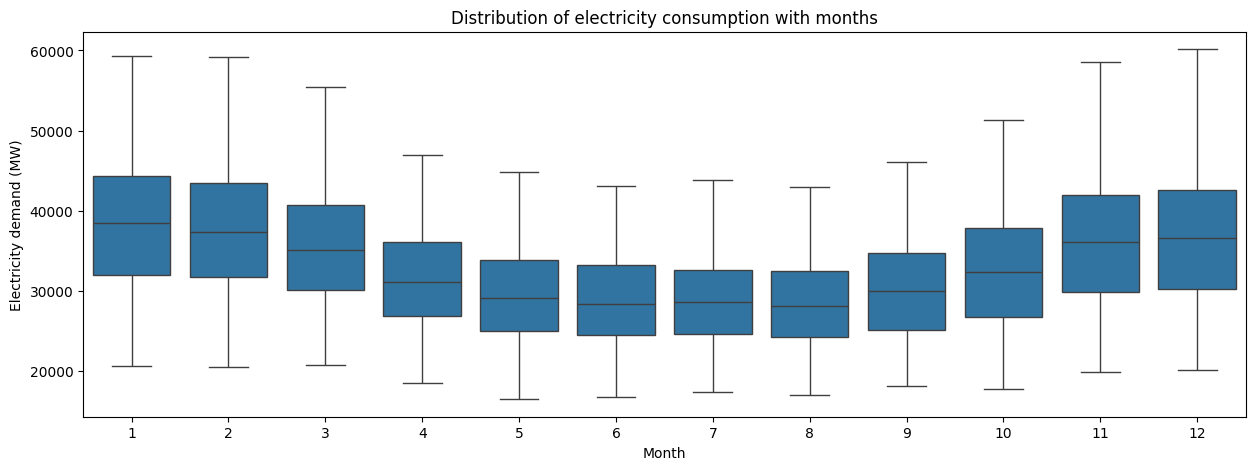

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="month", y="tsd", data=df)

ax.set_xlabel("Month")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with months");

It seems that the lowest consumption occurs during the summer months.

Let's plot for 2016, to make sure that I selected the right variable in the above plot.

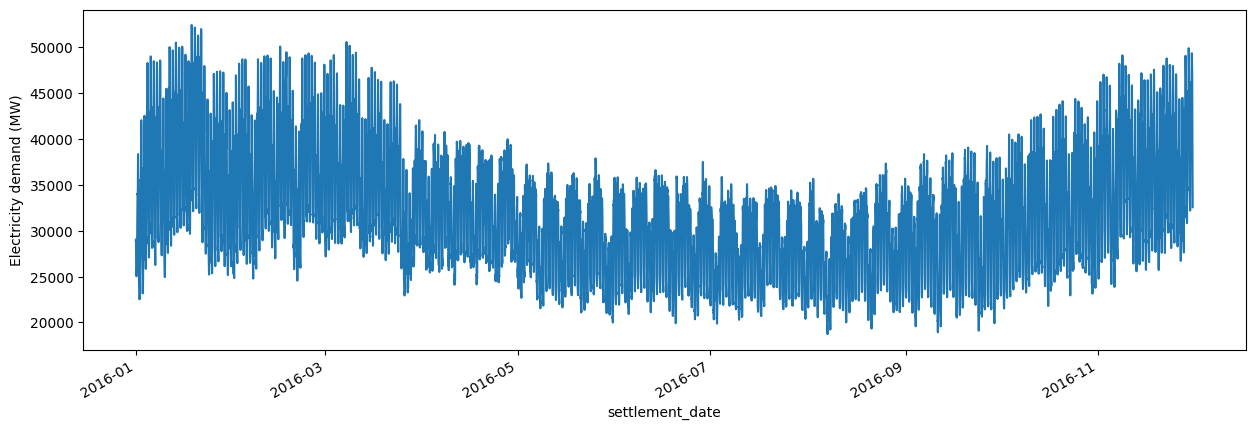

In [ ]:
df.loc[(df.index > "01-01-2016") & (df.index < "12-01-2016")]["tsd"].plot(
    figsize=(15, 5), ylabel="Electricity demand (MW)"
);

This plot supports the finding from the previous graph.

Let's look at the effect of bank holidays on electricity consumption.

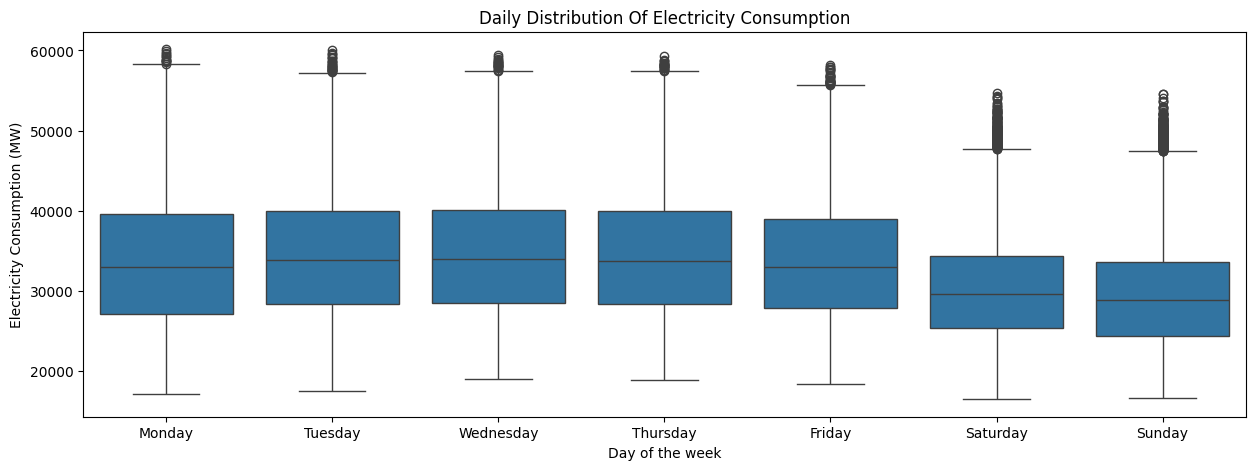

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="day_of_week", y="tsd", data=df, ax=ax)

ax.set_xticklabels(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)
ax.set_xlabel("Day of the week")
ax.set_ylabel("Electricity Consumption (MW)")
ax.set_title("Daily Distribution Of Electricity Consumption");

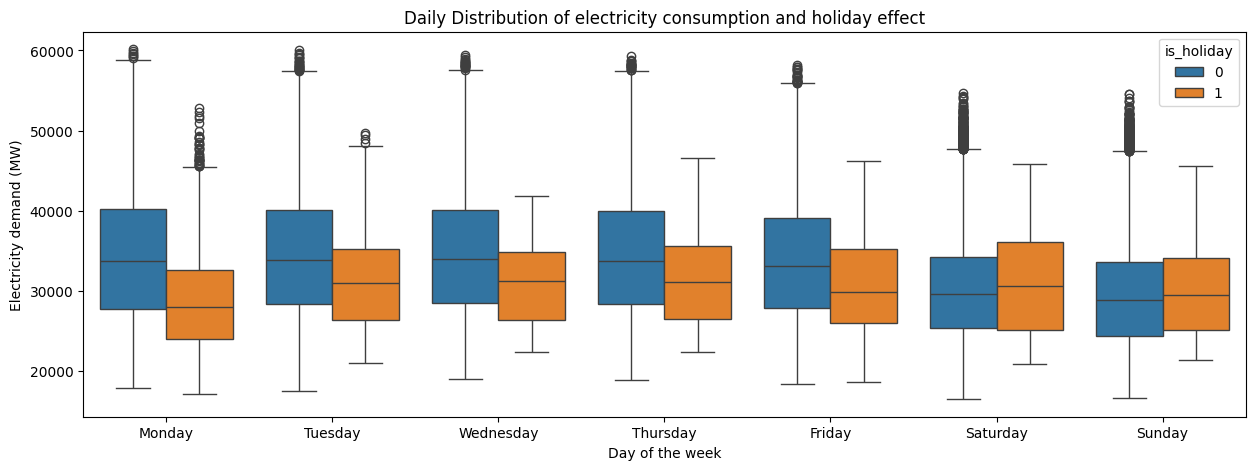

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="day_of_week", y="tsd", data=df, hue="is_holiday", ax=ax)

ax.set_xticklabels(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)
ax.set_xlabel("Day of the week")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Daily Distribution of electricity consumption and holiday effect");

It seems that from Monday to Friday, the electricity consumption is on average lower on bank holidays, whereas it is higher on Saturday and it's the same on Sundays.

For non bank holiday, the demand on the weekend is lower than during week days.

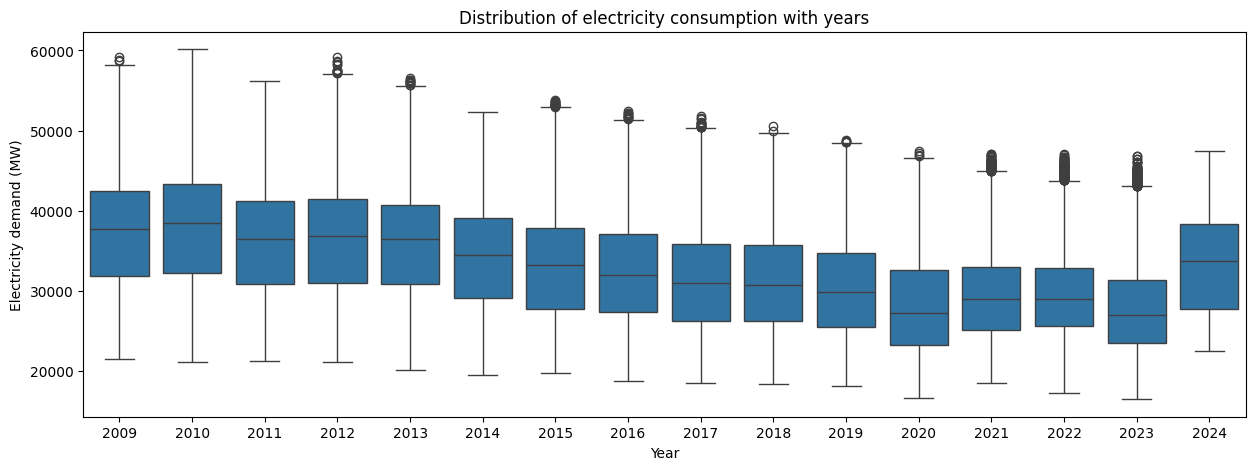

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="year", y="tsd", data=df)

ax.set_xlabel("Year")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with years");

Although these are yearly average values, one can see a decreasing trend in the electricity consumption over the years. We can overlay the electricity consumption of two years to see how they compare.


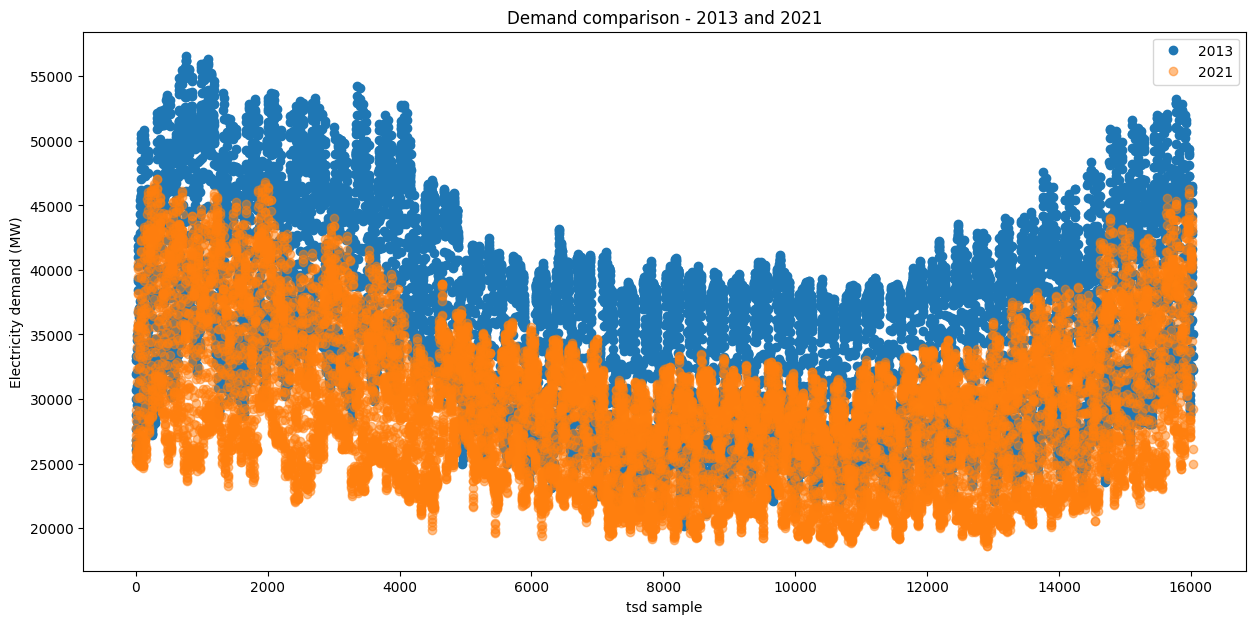

In [ ]:
fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(
    range(len(df.loc[(df.index > "01-01-2013") & (df.index < "12-01-2013")]["tsd"])),
    df.loc[(df.index > "01-01-2013") & (df.index < "12-01-2013")]["tsd"],
    "o",
    label="2013",
)

ax.plot(
    range(len(df.loc[(df.index > "01-01-2021") & (df.index < "12-01-2021")]["tsd"])),
    df.loc[(df.index > "01-01-2021") & (df.index < "12-01-2021")]["tsd"],
    "o",
    alpha=0.5,
    label="2021",
)
ax.set_xlabel("tsd sample")
ax.set_ylabel("Electricity demand (MW)")
ax.legend(loc="best")
ax.set_title("Demand comparison - 2013 and 2021");

Again, this plot confirms that electricity consumption is decreasing in recent years.

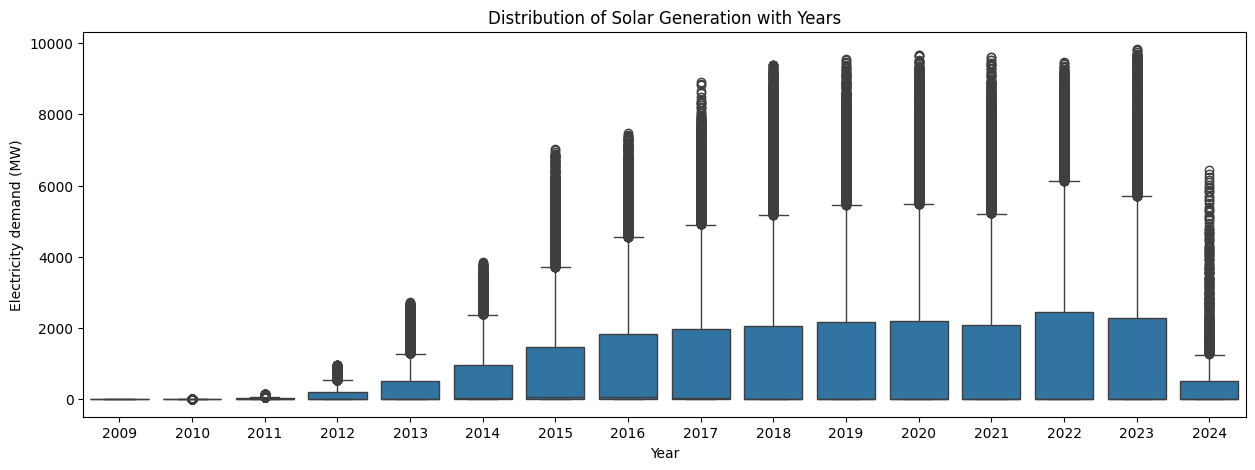

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="year", y="embedded_solar_generation", data=df)

ax.set_xlabel("Year")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of Solar Generation with Years");

We can see that the Solar generation has increased with the years and has been around constant over the past few years.

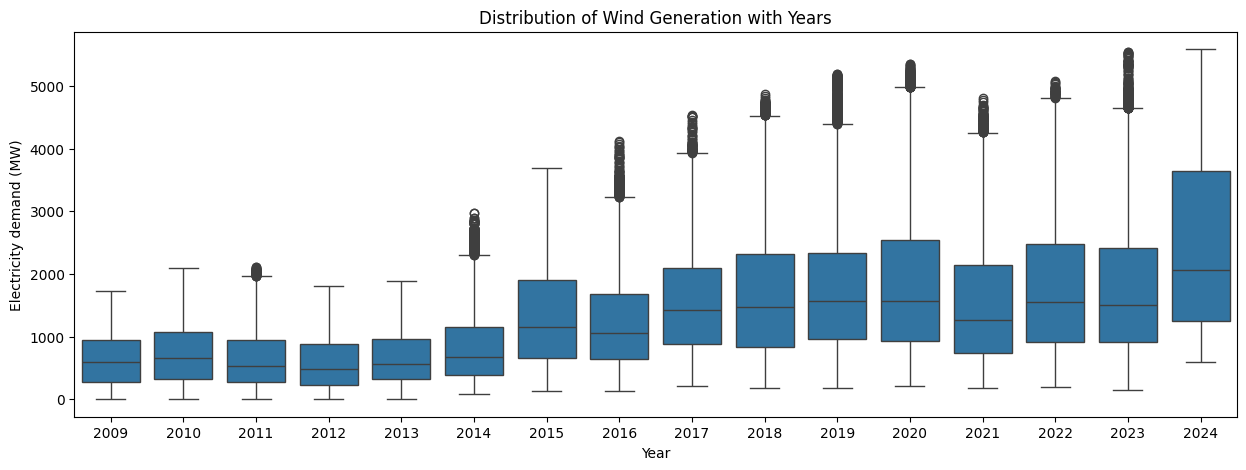

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="year", y="embedded_wind_generation", data=df)

ax.set_xlabel("Year")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of Wind Generation with Years");

We can see from the above graph that wind generation is being used from as backa s 2009 but it has grown significantly over the years.

# Time-series models

Once I've gained enough understanding of the time series data, I'm ready to create different models and check their accuracy on the predictions. In order to compare the results of the models, I will use the Mean Absolute Percentage Error, which I implemented as follows:

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):

   # Calculate Mean Absolute Pertange Error given the true and predicted value.
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

# **XGboost**

The forecasting method I will use is XGBoost. It isn't a forecasting tool per se, but a regression tool. While traditional regression techniques struggle with time series forecasting, XGBoost does a great job as we will see. Also, XGBoost can use multiple features instead of just the electricity demand.


**Simple XGBoost model**

The first XGBoost model is a simple model for which some of the parameters are defined and the data is split into train and test sets. This model is fairly simple, but it's a great baseline

**Training - test split**

The first step is to split the data. I will split the data into train, test and hold-out set. The hold-out set will be used for independent evaluation of the model while the model is being trained.



In [ ]:
threshold_date_1 = "06-01-2018"
threshold_date_2 = "06-01-2021"
train_data = df.loc[df.index < threshold_date_1]
test_data = df.loc[(df.index >= threshold_date_1) & (df.index < threshold_date_2)]
hold_out_data = df.loc[df.index >= threshold_date_2]

In [ ]:
train_data.columns

Index(['settlement_period', 'period_hour', 'nd', 'tsd', 'england_wales_demand',
       'embedded_wind_generation', 'embedded_wind_capacity',
       'embedded_solar_generation', 'embedded_solar_capacity', 'non_bm_stor',
       'pump_storage_pumping', 'ifa_flow', 'ifa2_flow', 'britned_flow',
       'moyle_flow', 'east_west_flow', 'nemo_flow', 'is_holiday',
       'day_of_month', 'day_of_week', 'day_of_year', 'quarter', 'month',
       'year', 'week_of_year', 'lag1', 'lag2', 'lag3'],
      dtype='object')

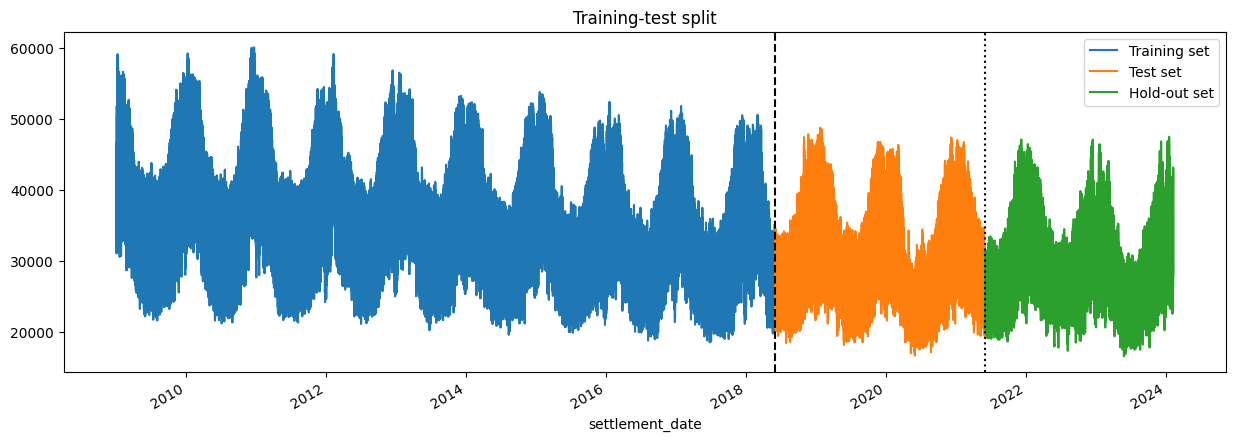

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
train_data["tsd"].plot(ax=ax, label="Training set")
test_data["tsd"].plot(ax=ax, label="Test set")
hold_out_data["tsd"].plot(ax=ax, label="Hold-out set")
ax.axvline(threshold_date_1, color="k", ls="--")
ax.axvline(threshold_date_2, color="k", ls=":")
ax.set_title("Training-test split")
plt.legend();

In [ ]:
# Define the features and target variable
FEATURES = [
    "is_holiday",
    "settlement_period",
    "day_of_month",
    "day_of_week",
    "day_of_year",
    "quarter",
    "month",
    "year",
    "week_of_year"]
TARGET = "tsd"

# Prepare the training, testing and hold-out data
X_train = train_data[FEATURES]
y_train = train_data[TARGET]

X_test = test_data[FEATURES]
y_test = test_data[TARGET]

X_hold_out = hold_out_data[FEATURES]
y_hold_out = hold_out_data[TARGET]

# Initialize and fit the XGBoost model
xgb_simple = xgb.XGBRegressor(
    n_estimators=1000,
    max_depth=3,
    learning_rate=0.01,
    early_stopping_rounds=100,
#     tree_method="gpu_hist",
    random_state=43,
)

xgb_simple.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_hold_out, y_hold_out)],
    verbose=100,
);

[0]	validation_0-rmse:7528.78210	validation_1-rmse:8422.62211
[100]	validation_0-rmse:4876.76773	validation_1-rmse:6675.67921
[200]	validation_0-rmse:3709.99776	validation_1-rmse:5709.72228
[300]	validation_0-rmse:3056.88401	validation_1-rmse:5172.00457
[400]	validation_0-rmse:2659.31979	validation_1-rmse:4843.34654
[500]	validation_0-rmse:2394.25942	validation_1-rmse:4608.25670
[600]	validation_0-rmse:2215.52209	validation_1-rmse:4456.35408
[700]	validation_0-rmse:2096.52046	validation_1-rmse:4380.15069
[800]	validation_0-rmse:2013.47444	validation_1-rmse:4308.73595
[900]	validation_0-rmse:1953.13358	validation_1-rmse:4267.54456
[999]	validation_0-rmse:1907.17434	validation_1-rmse:4231.17936


# **Feature importance**
Since there are multiple parameters, we can check the importance of each of them as follows:

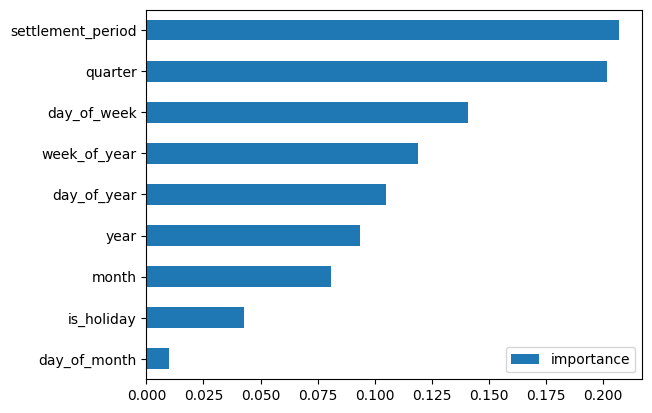

In [ ]:
feat_imp_1 = pd.DataFrame(
    data=xgb_simple.feature_importances_,
    index=xgb_simple.get_booster().feature_names,
    columns=["importance"],
)

feat_imp_1.sort_values("importance", ascending=True, inplace=True)

feat_imp_1.plot(kind="barh");

# **Forecast on test set**
Once the model is trained, it can be used to predict the demand on the test set.

In [ ]:
result_frame = y_test.to_frame()
result_frame["pred_xgb_simple"] = xgb_simple.predict(X_test)

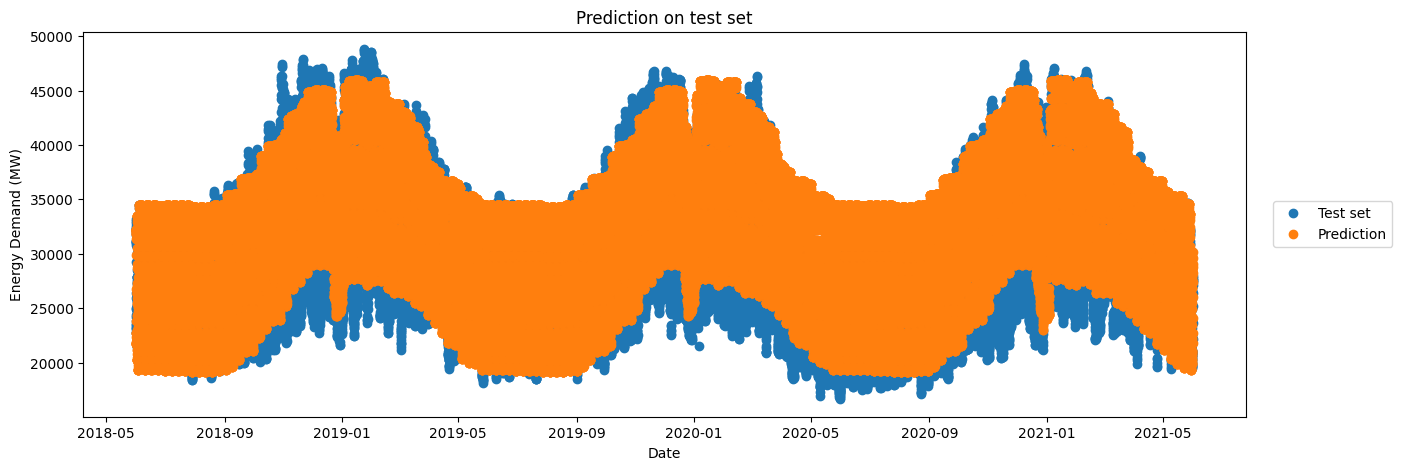

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["tsd"], "o", label="Test set")
ax.plot(result_frame.index, result_frame["pred_xgb_simple"], "o", label="Prediction")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

In [ ]:
mape_xgboost_simple = mean_absolute_percentage_error(
    y_test, result_frame["pred_xgb_simple"]
)

rmse_xgboost_simple = np.sqrt(mean_squared_error(y_test, result_frame["pred_xgb_simple"]))

print("Mean Absolute Percentage Error of the simple model is:",mape_xgboost_simple)

print("Root Mean Squared Error of the simple models is:",rmse_xgboost_simple, "MW")

Mean Absolute Percentage Error of the simple model is: 9.877487336167217
Root Mean Squared Error of the simple models is: 3553.9456499414205  MW


# **XGBoost with Cross validation and Grid Search**

The model above is a good starting point, but it's still underfitted to the data. One can run the model again and change the hyperparameters,but it isn't the right way to train a model if we want to avoid overfitting. This problem can be solved by using cross validation and grid search.

# **Cross Validation for time series**

The first step is to create the data split for cross validation. Luckily, sklearn includes the class TimeSeriesSplit that will get the job done. Let's split the data and see what it looks like:

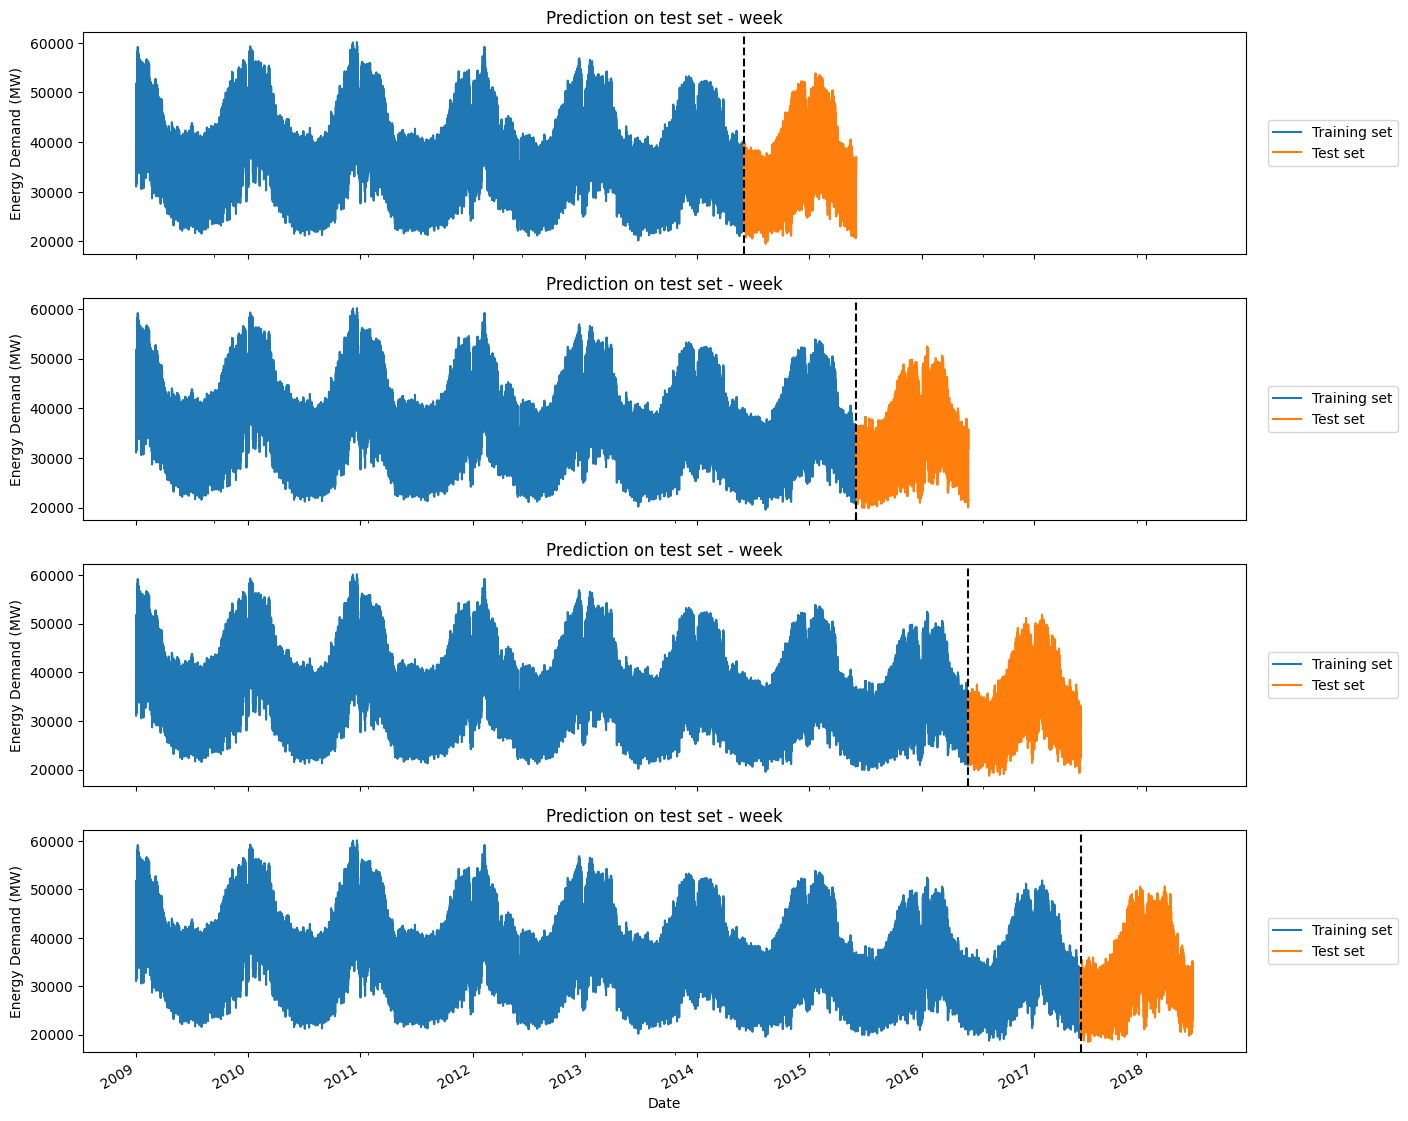

In [ ]:
n_years_test = 1
tss = TimeSeriesSplit(n_splits=4, test_size=48 * 365 * n_years_test, gap=48)

fig, axes = plt.subplots(4, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_index, test_index in tss.split(df[df.index<threshold_date_1]):

    train = df.iloc[train_index]
    test = df.iloc[test_index]

    train["tsd"].plot(
        ax=axes[fold], label="Training set", title=f"Data Train-test split fold {fold}",
    )
    test["tsd"].plot(ax=axes[fold], label="Test set")
    axes[fold].axvline(test.index.min(), color="k", ls="--")
    axes[fold].legend(loc="center", bbox_to_anchor=(1.075, 0.5))

    axes[fold].set_title("Prediction on test set - week")
    axes[fold].set_ylabel("Energy Demand (MW)")
    axes[fold].set_xlabel("Date");
    fold += 1

In [ ]:
%%time

train_data.index = pd.Index(train_data.index)
test_data.index = pd.Index(test_data.index)

FEATURES_CV = [
    "settlement_period",
    "day_of_month",
    "day_of_week",
    "day_of_year",
    "quarter",
    "month",
    "year",
    "week_of_year",
    "lag1",
    "lag2",
    "lag3",
    "is_holiday",
]
TARGET = "tsd"

# Define train, test and hold-out set for the cv features
X_train_cv = train_data[FEATURES_CV]
y_train_cv = train_data[TARGET]

X_test_cv = test_data[FEATURES_CV]
y_test_cv = test_data[TARGET]

X_hold_out = hold_out_data[FEATURES_CV]
y_hold_out = hold_out_data[TARGET]


# Define fit parameters to allow early stopping in GridSearchCV
fit_params = {
    "early_stopping_rounds": 50,
    "eval_metric": "rmse",
    "eval_set": [[X_hold_out, y_hold_out]],
}

# Define estimator
estimator = xgb.XGBRegressor(
    base_score=0.5,
    booster="gbtree",
    learning_rate=0.01,
    tree_method="gpu_hist",
    random_state=43,
)

# Define parameters to optimiser
param_search = {
    "max_depth": [3, 5],
    "n_estimators": [350, 500, 650],
    "subsample": [0.95, 0.8, 0.7],
}


# Create GridSearchCV object
xgb_search = GridSearchCV(
    estimator=estimator,
    cv=tss,
    param_grid=param_search,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

xgb_search.fit(X_train_cv, y_train_cv, verbose=500, **fit_params);

Fitting 4 folds for each of 18 candidates, totalling 72 fits
[0]	validation_0-rmse:29223.00326
[349]	validation_0-rmse:2578.32496
[CV 1/4] END max_depth=3, n_estimators=350, subsample=0.95;, score=-1974.036 total time=   1.4s
[0]	validation_0-rmse:29224.51632
[349]	validation_0-rmse:2536.12774
[CV 2/4] END max_depth=3, n_estimators=350, subsample=0.95;, score=-2037.863 total time=   1.3s
[0]	validation_0-rmse:29226.27373
[349]	validation_0-rmse:2591.55157
[CV 3/4] END max_depth=3, n_estimators=350, subsample=0.95;, score=-2567.851 total time=   1.5s
[0]	validation_0-rmse:29227.31757
[349]	validation_0-rmse:2602.94788
[CV 4/4] END max_depth=3, n_estimators=350, subsample=0.95;, score=-2785.788 total time=   1.3s
[0]	validation_0-rmse:29223.03631
[349]	validation_0-rmse:2575.83964
[CV 1/4] END max_depth=3, n_estimators=350, subsample=0.8;, score=-1973.152 total time=   0.8s
[0]	validation_0-rmse:29224.47027
[349]	validation_0-rmse:2529.94957
[CV 2/4] END max_depth=3, n_estimators=350, su

GridSearchCV(cv=TimeSeriesSplit(gap=48, max_train_size=None, n_splits=4, test_size=17520),
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=Non...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=43, ...),
             param_grid={'max_depth': [3, 5], 'n_estimators': [350, 500, 650],
                         'subsample': [0.95, 0.8, 0.7]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [ ]:
xgb_search.best_params_

{'max_depth': 5, 'n_estimators': 500, 'subsample': 0.8}

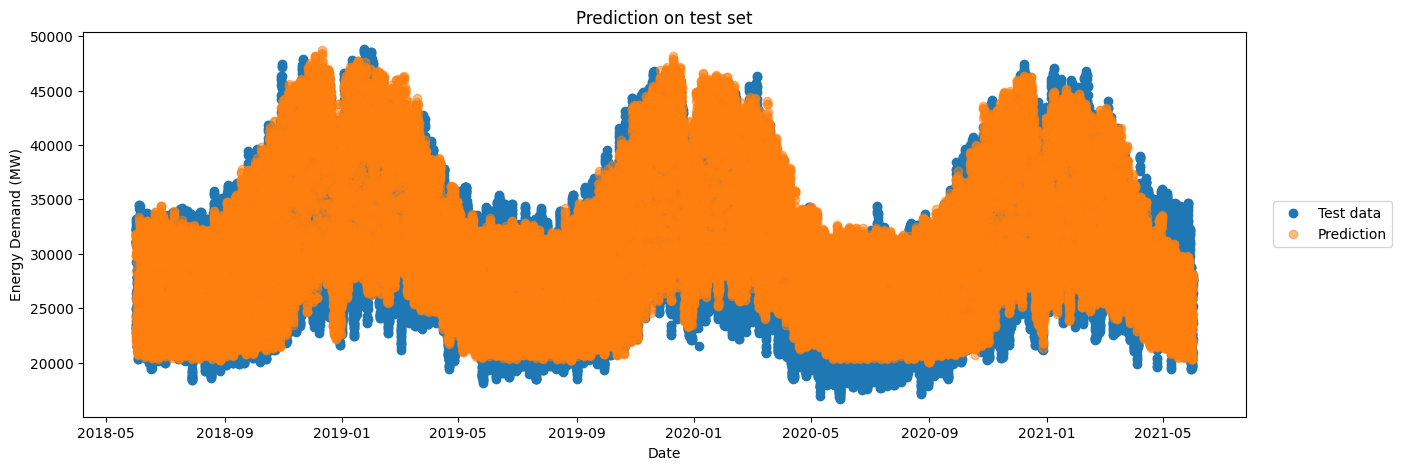

In [ ]:
result_frame["pred_xgb_cv_gs"] = xgb_search.predict(X_test_cv)

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["tsd"], "o", label="Test data")
ax.plot(
    result_frame.index,
    result_frame["pred_xgb_cv_gs"],
    "o",
    label="Prediction",
    alpha=0.5,
)

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

In [ ]:
mape_xgboost_cv = mean_absolute_percentage_error(y_test, result_frame["pred_xgb_cv_gs"])

rmse_xgboost_cv = np.sqrt(mean_squared_error(y_test, result_frame["pred_xgb_cv_gs"]))
print("Mean Absolute Percentage Error of the cross-validated model is: %.2f"% mape_xgboost_cv)

print("Root Mean Squared Error of the cross-validated model is: %.2f MW" % rmse_xgboost_cv)

Mean Absolute Percentage Error of the cross-validated model is: 7.09
Root Mean Squared Error of the cross-validated model is: 2653.26 MW


# **Prediction into the future**
Now that the best parameters have been found, the model can be fit using the entire dataset to then predict into the future.

In [ ]:
X_all = df[FEATURES_CV]
y_all = df[TARGET]

xgb_best = xgb_search.best_estimator_
xgb_best.set_params(n_jobs=-1)
xgb_best.fit(
    X_all,
    y_all,
    eval_set=[(X_all, y_all)],
    verbose=100,
    early_stopping_rounds=50,
);

[0]	validation_0-rmse:33510.28087
[100]	validation_0-rmse:12510.56519
[200]	validation_0-rmse:5088.13067
[300]	validation_0-rmse:2755.08021
[400]	validation_0-rmse:2144.17123
[499]	validation_0-rmse:1960.10794


The next step is to build a dataframe that goes into the future:

In [ ]:
def settlement_period(df):
    df = df.copy()

    settlement_period_array = (
        np.array(df.index.hour.to_list()) * 2 + np.array(df.index.minute.to_list()) / 30 + 1
    ).astype(int)


    df["hourly_period"] = settlement_period_array

    return df

In [ ]:
prediction_days = 210

future = pd.date_range(
    str(df.index.max())[0:10],
    df.index.max() + datetime.timedelta(days=prediction_days),
    freq="30min",
)

future_df = pd.DataFrame(index=future)
future_df = settlement_period(future_df)
future_df["is_future"] = True
df["is_future"] = False

# Create a dataframe containing the original data and the predict df
df_and_future = pd.concat([df, future_df])

# add features and lag
# lag values will change w.r.t original dataframe
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

# add bank holidays in future dataframe
df_and_future_wprediction = df_and_future.query("is_future").copy()

df_and_future_wprediction["date"] = df_and_future_wprediction.index.date
df_and_future_wprediction["is_holiday"] = df_and_future_wprediction["date"].apply(
    lambda x: pd.to_datetime(x) in holiday_dates_observed
)
df_and_future_wprediction["is_holiday"] = df_and_future_wprediction["is_holiday"].astype(int)

df_and_future_wprediction.tail()

,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,...,quarter,month,year,week_of_year,lag1,lag2,lag3,is_future,hourly_period,date
2024-09-05 21:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3,9,2024,36,30492.0,32539.0,30648.0,True,44.0,2024-09-05
2024-09-05 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3,9,2024,36,28680.0,31141.0,29552.0,True,45.0,2024-09-05
2024-09-05 22:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3,9,2024,36,27144.0,29689.0,28347.0,True,46.0,2024-09-05
2024-09-05 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3,9,2024,36,25955.0,28551.0,27184.0,True,47.0,2024-09-05
2024-09-05 23:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3,9,2024,36,25070.0,27726.0,26005.0,True,48.0,2024-09-05


In [ ]:
df_and_future_wprediction.shape

(10128, 32)

As can be seen, the last rows of the new dataframe go into the future.

Now, the XGBoost model can be used to predict into the future:

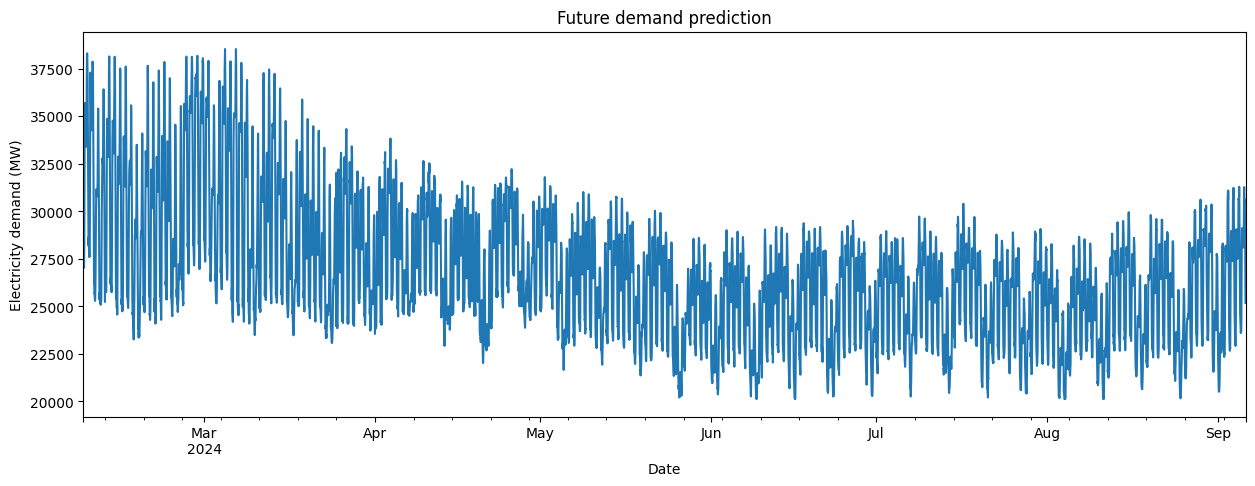

In [ ]:
df_and_future_wprediction["pred_xgboost"] = xgb_best.predict(
    df_and_future_wprediction[FEATURES_CV]
)


fig, ax = plt.subplots(figsize=(15, 5))
df_and_future_wprediction["pred_xgboost"].plot(figsize=(15, 5), style="-", ax=ax)
ax.set_xlabel("Date")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Future demand prediction");

In [ ]:
df_and_future_wprediction.tail()

,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,...,month,year,week_of_year,lag1,lag2,lag3,is_future,hourly_period,date,pred_xgboost
2024-09-05 21:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9,2024,36,30492.0,32539.0,30648.0,True,44.0,2024-09-05,28949.804688
2024-09-05 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9,2024,36,28680.0,31141.0,29552.0,True,45.0,2024-09-05,27984.681641
2024-09-05 22:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9,2024,36,27144.0,29689.0,28347.0,True,46.0,2024-09-05,26967.646484
2024-09-05 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9,2024,36,25955.0,28551.0,27184.0,True,47.0,2024-09-05,26108.470703
2024-09-05 23:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9,2024,36,25070.0,27726.0,26005.0,True,48.0,2024-09-05,25174.335938
